# Prédiction des émissions de carbone

## Importation librairies et données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
%matplotlib inline

sns.set(font_scale=1.8)

from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import shap
shap.initjs()

In [2]:
data = pd.read_csv('data.csv').drop(columns=['SiteEnergyUseWN(kBtu)'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Columns: 251 entries, BuildingAge to ThirdLargestPropertyUseType_Worship Facility
dtypes: float64(251)
memory usage: 2.8 MB


## Standardisation des variables avec le Standard Scaler

In [3]:
scaler= StandardScaler()
features = data.drop(columns='TotalGHGEmissions').columns

X = data.drop(columns='TotalGHGEmissions')
X = pd.DataFrame(scaler.fit_transform(X),columns=features)

y = data['TotalGHGEmissions']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


## Première prédiction des données de test avec 11 modèles

In [4]:
regressors = [
    ["Dummy",DummyRegressor()],
    ['linear', LinearRegression()],
    ['lasso',Lasso()],
    ['ridge',Ridge()],
    ['elasticnet',ElasticNet()],
    ['KNN',KNeighborsRegressor()],
    ['decisiontree',DecisionTreeRegressor()],
    ['extratree',ExtraTreesRegressor()],
    ['randomforest',RandomForestRegressor()],
    ['Gradient',GradientBoostingRegressor()],
    ['xgboost',XGBRegressor()]
]



In [5]:
results = pd.DataFrame()
pd.options.display.float_format = '{:20,.2f}'.format

results['regressor_name'] = [item[0] for item in regressors] 
results['regressors'] = [item[1] for item in regressors] 


    
for model in [item[1] for item in regressors]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.loc[results['regressors']==model,"RMSE"] =  np.sqrt(mean_squared_error(y_test, y_pred))        
        results.loc[results['regressors']==model,"MAE"] =  mean_absolute_error(y_test, y_pred)
        results.loc[results['regressors']==model,'R2_score'] = r2_score(y_test, y_pred)

results

,regressor_name,regressors,RMSE,MAE,R2_score
0,Dummy,DummyRegressor(),213.51,135.13,-0.00
1,linear,LinearRegression(),"6,585,146,591,678,473.00","1,019,586,526,752,381.38","-953,278,011,210,526,152,974,139,392.00"
2,lasso,Lasso(),165.19,87.70,0.40
3,ridge,Ridge(),234.94,109.86,-0.21
4,elasticnet,ElasticNet(),151.89,79.20,0.49
5,KNN,KNeighborsRegressor(),170.90,85.62,0.36
6,decisiontree,DecisionTreeRegressor(),157.12,75.12,0.46
7,extratree,"(ExtraTreeRegressor(random_state=907500721), E...",120.76,62.08,0.68
8,randomforest,"(DecisionTreeRegressor(max_features='auto', ra...",119.98,62.06,0.68
9,Gradient,([DecisionTreeRegressor(criterion='friedman_ms...,126.60,70.57,0.65


In [6]:
kf = KFold(n_splits=10,shuffle=True)
j=0
df=pd.DataFrame(columns=[item[0] for item in regressors])

for model,name in zip([item[1] for item in regressors],[item[0] for item in regressors]):
    score =[]

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_X, train_y = X.iloc[train_index],y.iloc[train_index]
        valid_X, valid_y = X.iloc[test_index],y.iloc[test_index]
        model.fit(train_X,train_y)
        y_pred = model.predict(valid_X)
        score.append(r2_score(valid_y, y_pred))
    
    df.iloc[:,j]=score
    j=j+1
    
df

,Dummy,linear,lasso,ridge,elasticnet,KNN,decisiontree,extratree,randomforest,Gradient,xgboost
0,-0.00,"-3,638,785,168,183,713,465,972,555,776.00",0.51,0.40,0.24,0.45,0.21,0.67,0.49,0.54,0.27
1,-0.01,"-7,031,234,084,946,496,712,303,706,112.00",-0.02,0.00,0.42,0.15,0.17,0.60,0.62,0.59,0.48
2,-0.03,"-2,246,023,499,596,644,999,189,495,808.00",0.21,-0.15,0.67,0.34,0.21,0.44,0.60,0.44,0.61
3,-0.00,"-90,163,168,182,856,475,121,549,312.00",0.57,0.29,0.49,0.33,0.35,0.06,0.40,0.70,0.50
4,-0.00,"-23,752,951,574,344,062,472,290,304.00",0.61,0.14,0.40,0.28,-0.05,0.52,0.74,0.60,0.46
5,-0.01,"-513,067,481,240,292,535,023,173,632.00",0.41,0.04,0.50,0.12,-1.02,0.73,0.62,0.58,0.45
6,-0.00,"-166,080,767,466,153,010,660,376,576.00",0.55,0.58,0.39,0.31,0.43,0.46,0.63,0.48,0.70
7,-0.00,"-8,543,550,167,287,893,658,282,491,904.00",0.54,-0.21,0.43,0.18,0.25,0.34,0.44,0.57,0.60
8,-0.00,"-2,398,341,915,482,071,686,472,269,824.00",0.49,0.32,0.58,0.35,0.19,0.38,0.70,0.58,0.46
9,-0.00,"-48,370,193,593,533,453,141,186,445,312.00",0.24,0.47,0.44,0.15,-0.21,0.51,0.25,0.54,0.45


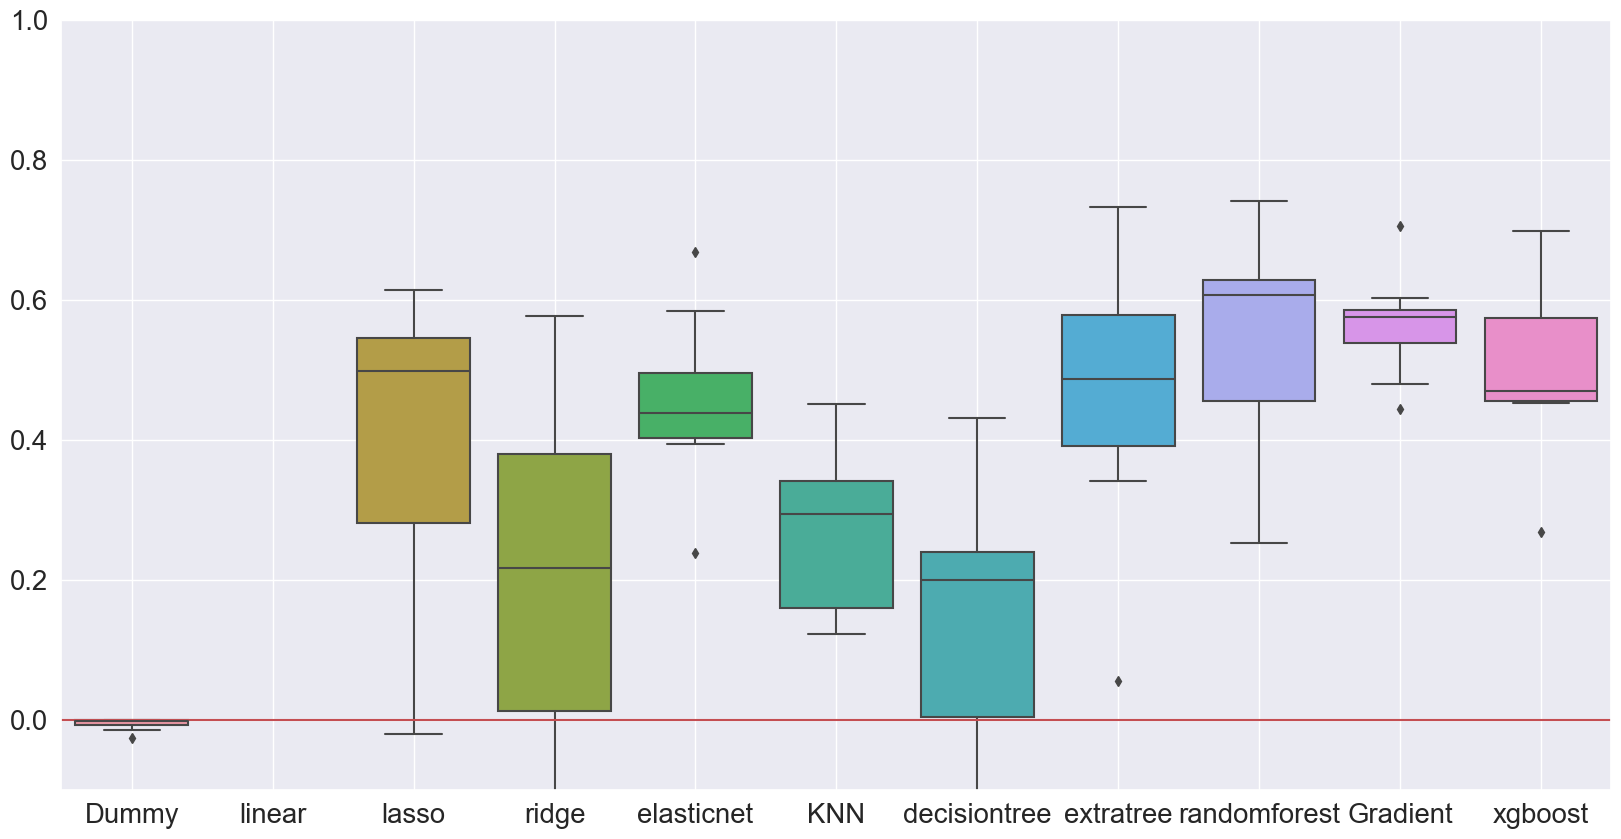

In [7]:
plt.figure(figsize=[20,10])
sns.boxplot(data=df)
ax = plt.gca()
ax.set_ylim([-0.1, 1])
plt.axhline(y=0, color='r', linestyle='-')
ax.grid(True)



### On constate que les modèles les plus performants sont le Gradient Boosting Regressor, l'extratrees, le linear, le lasso, le ridge, le Xboost et le RandomForest.

# GridSearch sur les meilleurs modèles

In [8]:
# set_models and params 

models = [
    [ElasticNet(), {
    "alpha" : [1,2,3,4,5,6,7,8,9,10],
    "l1_ratio" : [0.2,0.5,0.8],
    "random_state" :  [133]
}],
    [Ridge(), {
    "alpha" : [1,2,3,4,5,6,7,8,9,10],
    "random_state" :  [133]
}],
    [Lasso(), {
    "alpha" : [1,2,3,4,5,6,7,8,9,10],
    "random_state" :  [133]
}],
    [RandomForestRegressor(), {
    "n_estimators" : [50,100,200,400],
    "max_depth" : [4,5,6],
    "max_features" : [None, 'sqrt', 'log2'],
    "random_state" :  [133]
}],
    [GradientBoostingRegressor(), {
    "learning_rate" : [0.01,0.05,0.1],
    "n_estimators" : [50,100,200,400],
    "max_depth" : [4,5,6],
    "max_features" : ['auto', 'sqrt', 'log2'],
    "random_state" :  [133]
}],
    [ExtraTreesRegressor(), {
    "max_depth" : [4,5,6],
    "max_features" : ['auto', 'sqrt', 'log2'],
    "random_state" :  [133]
}],
    [XGBRegressor(), {
    "n_estimators" : [50,100,200,400],
    "max_depth" : [4,5,6],
    "gamma" : [0.01,0.1],
    "learning_rate" : [0.01,0.05,0.1],
    "random_state" :  [133]
}]
]


In [9]:
good_regressors = []
for model in models : 
    
    GS = GridSearchCV(estimator = model[0],
                 param_grid = model[1],
                 scoring = ['r2','neg_root_mean_squared_error'],
                 refit='r2',
                 cv=10)
    
    GS.fit(X_train,y_train)
    
    print(model[0])
    print(GS.best_params_)
    print(GS.best_score_)
    print('\t')
    
    good_regressors.append(GS.best_estimator_)

ElasticNet()
{'alpha': 1, 'l1_ratio': 0.8, 'random_state': 133}
0.45863855766422645
	
Ridge()
{'alpha': 10, 'random_state': 133}
0.3960362932560221
	
Lasso()
{'alpha': 6, 'random_state': 133}
0.4851086337604832
	
RandomForestRegressor()
{'max_depth': 6, 'max_features': None, 'n_estimators': 100, 'random_state': 133}
0.500170113839901
	
GradientBoostingRegressor()
{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 133}
0.5704520311001898
	
ExtraTreesRegressor()
{'max_depth': 6, 'max_features': 'auto', 'random_state': 133}
0.4495110671819419
	
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, m

In [10]:
good_regressors_name=['elastic','ridge','lasso','randomforest','gradient','extratree','xgboost']

In [11]:
kf = KFold(n_splits=10,shuffle=True)
j=0
df=pd.DataFrame(columns= good_regressors_name)

for model,name in zip(good_regressors,good_regressors_name):
    score =[]

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_X, train_y = X.iloc[train_index],y.iloc[train_index]
        valid_X, valid_y = X.iloc[test_index],y.iloc[test_index]
        model.fit(train_X,train_y)
        y_pred = model.predict(valid_X)
        score.append(r2_score(valid_y, y_pred))
    
    df.iloc[:,j]=score
    j=j+1
    
df

,elastic,ridge,lasso,randomforest,gradient,extratree,xgboost
0,0.56,0.55,0.56,0.61,0.53,0.63,0.53
1,0.33,0.45,0.41,0.39,0.43,0.54,0.55
2,0.53,0.55,0.42,0.54,0.40,0.40,0.55
3,0.28,-0.63,0.54,0.53,0.64,0.54,0.41
4,0.65,0.21,0.47,0.56,0.67,0.38,0.47
5,0.45,-0.06,0.47,0.47,0.51,0.33,0.81
6,0.55,0.50,0.36,0.53,0.54,0.40,0.53
7,0.52,0.05,0.52,0.38,0.69,0.65,0.39
8,0.31,0.39,0.52,0.46,0.59,0.36,0.61
9,0.44,0.27,0.38,0.42,0.66,0.51,0.41


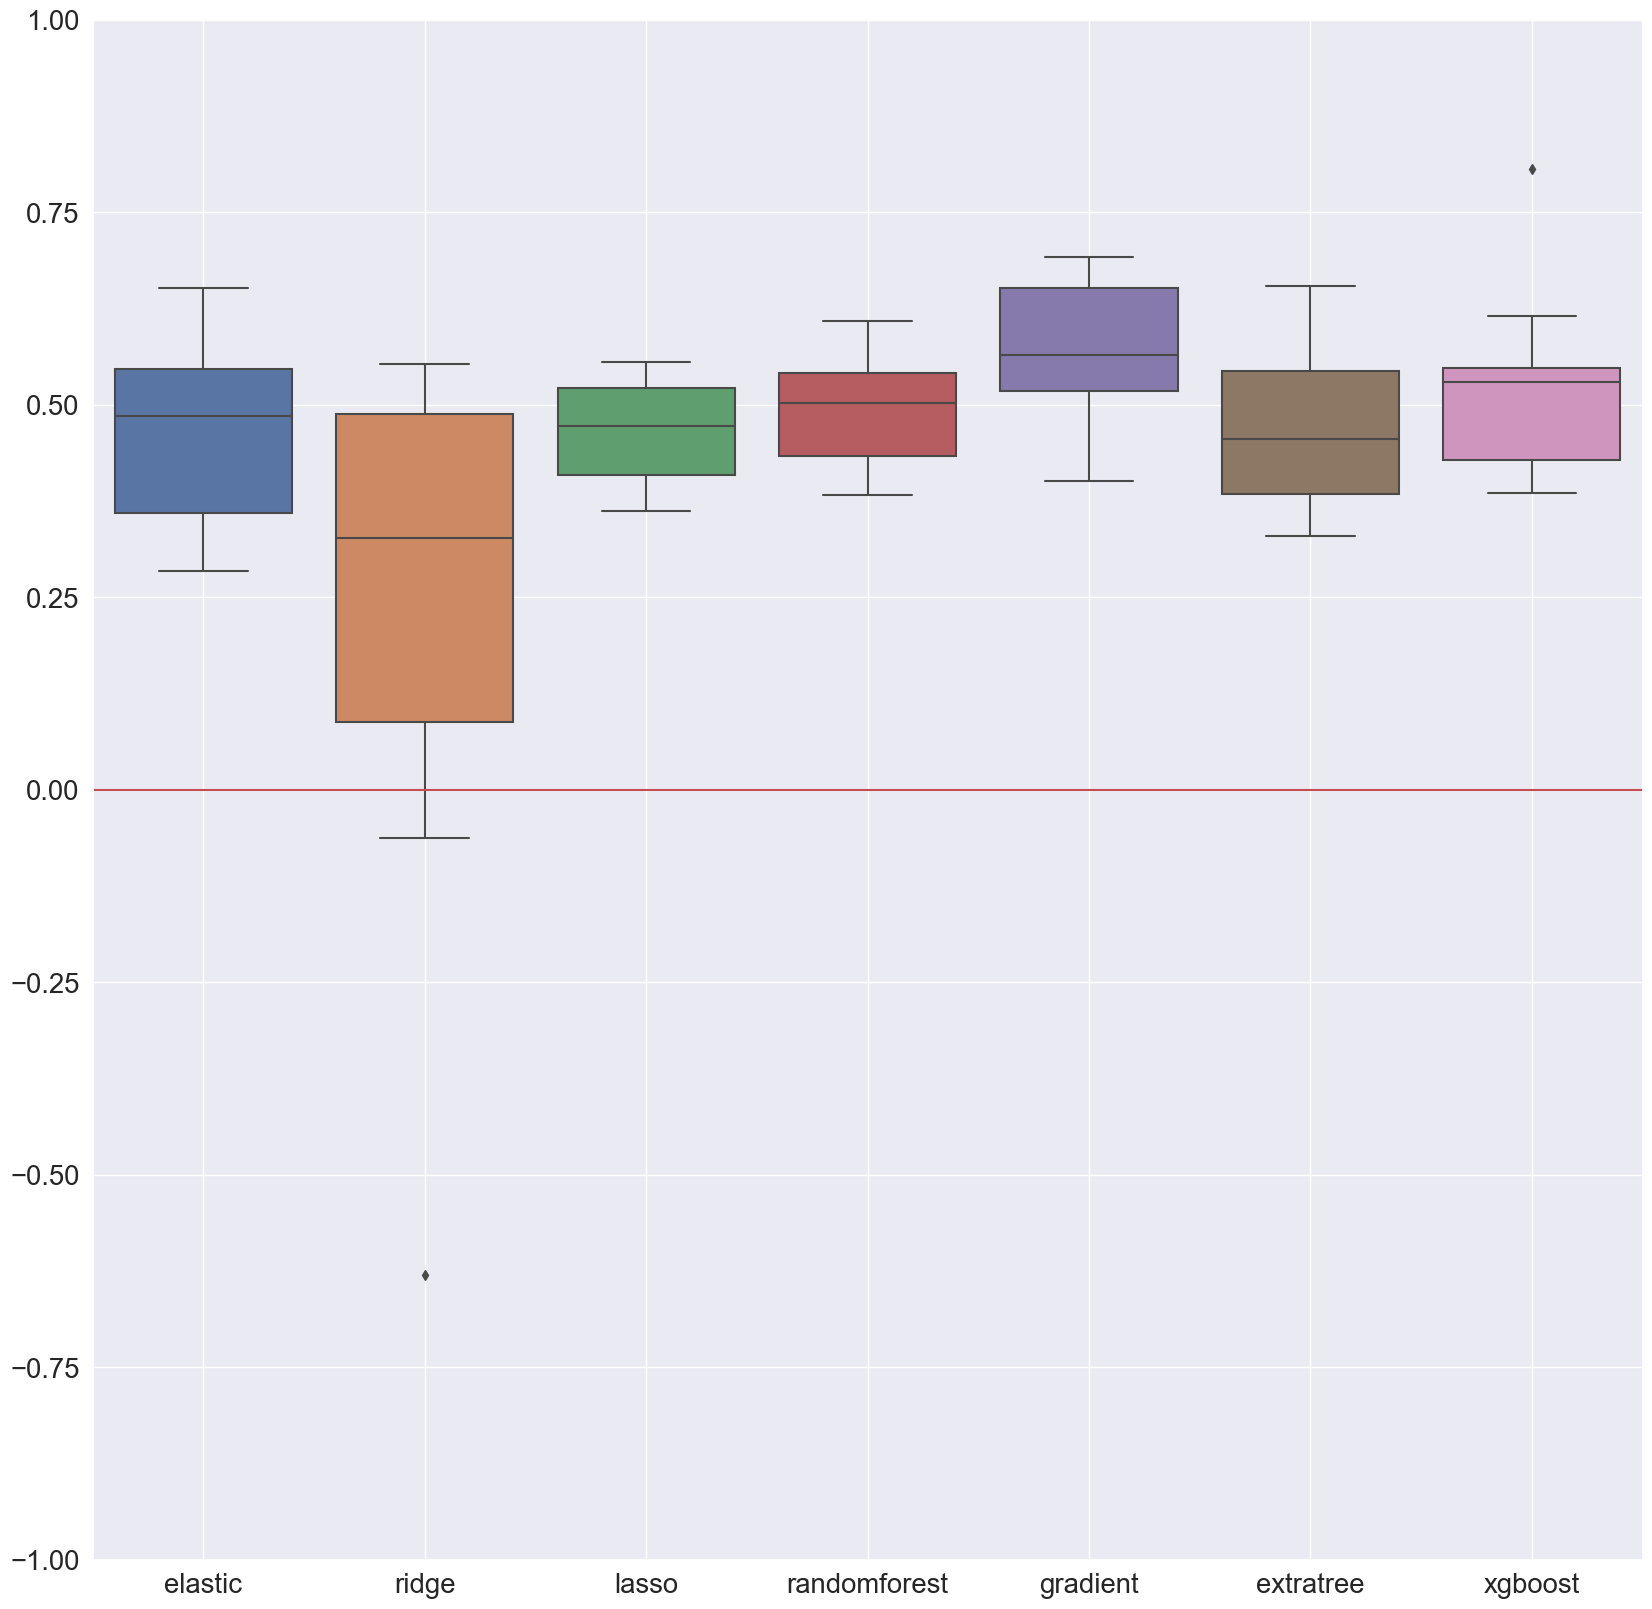

In [12]:
plt.figure(figsize=[20,20])
sns.boxplot(data=df)
ax = plt.gca()
ax.set_ylim([-1, 1])
plt.axhline(y=0, color='r', linestyle='-')
ax.grid(True)



In [13]:
kf = KFold(n_splits=10,shuffle=True)
j=0
df=pd.DataFrame(columns= good_regressors_name)

X_copy=X.drop(columns='ENERGYSTARScore')

for model,name in zip(good_regressors,good_regressors_name):
    score =[]

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_X, train_y = X_copy.iloc[train_index],y.iloc[train_index]
        valid_X, valid_y = X_copy.iloc[test_index],y.iloc[test_index]
        model.fit(train_X,train_y)
        y_pred = model.predict(valid_X)
        score.append(r2_score(valid_y, y_pred))
    
    df.iloc[:,j]=score
    j=j+1
    
df

,elastic,ridge,lasso,randomforest,gradient,extratree,xgboost
0,0.13,0.44,0.52,0.44,0.50,0.49,0.53
1,0.60,-1.21,0.46,0.42,0.60,0.58,0.59
2,0.56,0.43,0.57,0.30,0.37,0.55,0.50
3,0.31,0.33,0.39,0.56,0.70,0.45,0.68
4,0.50,0.48,0.49,0.61,0.50,0.61,0.23
5,0.68,0.38,0.46,0.62,0.66,0.36,0.54
6,0.54,0.68,0.46,0.34,0.27,0.52,0.58
7,0.34,0.42,0.37,0.50,0.39,0.60,0.56
8,0.41,-0.04,0.42,0.59,0.47,0.38,0.42
9,0.34,0.45,0.38,0.41,0.63,0.37,0.48


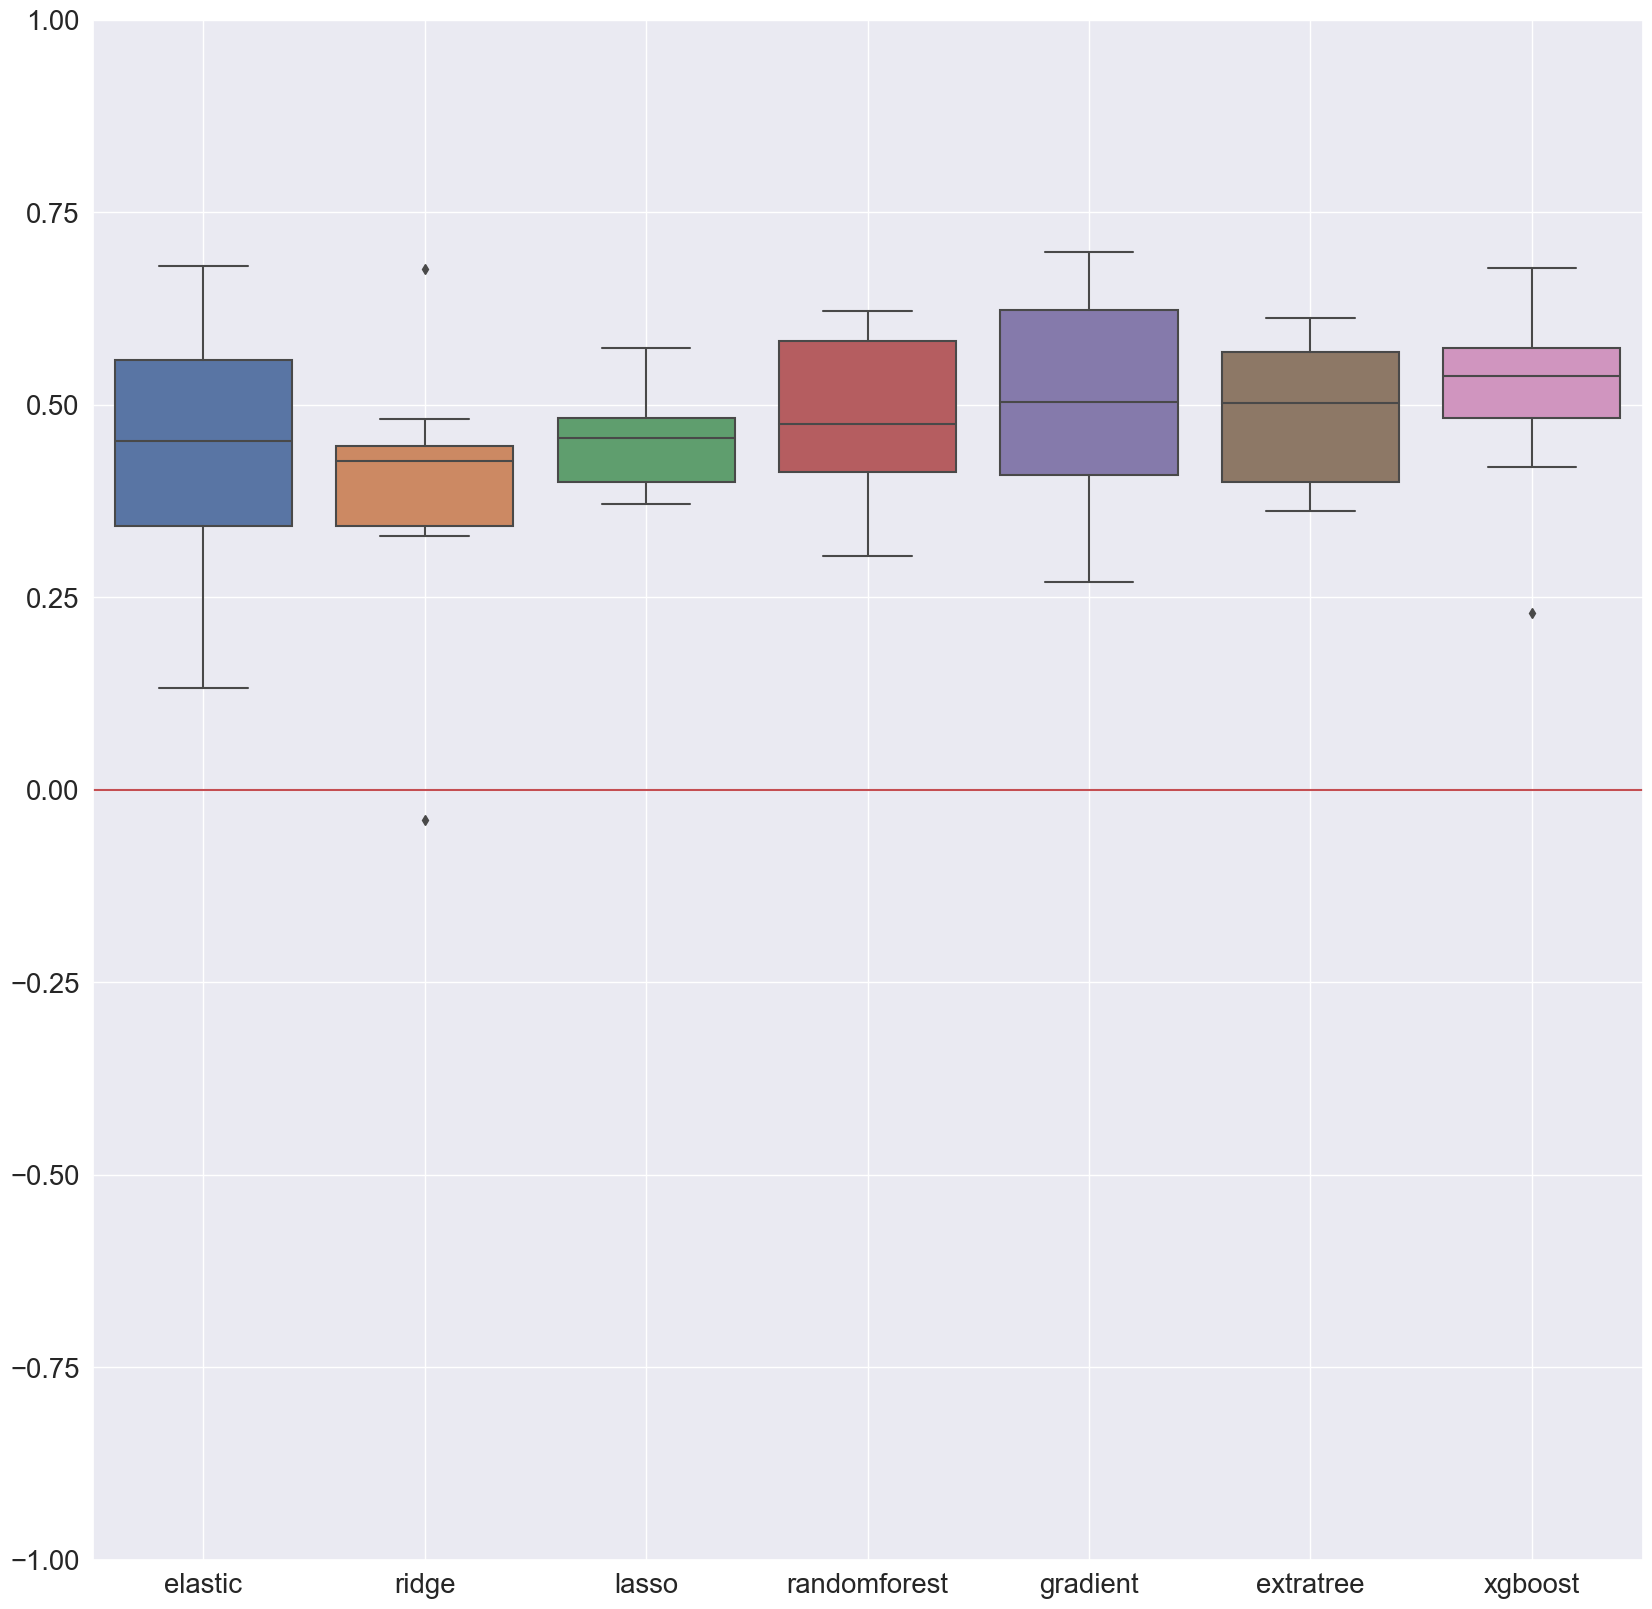

In [14]:
plt.figure(figsize=[20,20])
sns.boxplot(data=df)
ax = plt.gca()
ax.set_ylim([-1, 1])
plt.axhline(y=0, color='r', linestyle='-')
ax.grid(True)


## Validation des bons régresseurs sur les données de test : comparaison avec ou sans EnergyStarScore

In [15]:
results = pd.DataFrame()
pd.options.display.float_format = '{:20,.2f}'.format

results['regressors'] = good_regressors_name 

X_train_copy = X_train.drop(columns='ENERGYSTARScore')
X_test_copy = X_test.drop(columns='ENERGYSTARScore')

for model,name in zip(good_regressors,good_regressors_name):
        model.fit(X_train_copy, y_train)
        y_pred = model.predict(X_test_copy)
        results.loc[results['regressors']==name,"RMSE"] =  np.sqrt(mean_squared_error(y_test, y_pred))        
        results.loc[results['regressors']==name,"MAE"] =  mean_absolute_error(y_test, y_pred)
        results.loc[results['regressors']==name,'R2_score'] = r2_score(y_test, y_pred)
results.sort_values(ascending=False,by="R2_score")

,regressors,RMSE,MAE,R2_score
4,gradient,121.84,67.01,0.67
3,randomforest,130.80,74.72,0.62
6,xgboost,131.86,68.71,0.62
5,extratree,148.33,82.38,0.52
0,elastic,153.42,80.70,0.48
2,lasso,154.06,79.85,0.48
1,ridge,186.58,99.22,0.23


In [16]:
results = pd.DataFrame()
pd.options.display.float_format = '{:20,.2f}'.format

results['regressors'] = good_regressors_name 

for model,name in zip(good_regressors,good_regressors_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.loc[results['regressors']==name,"RMSE"] =  np.sqrt(mean_squared_error(y_test, y_pred))        
        results.loc[results['regressors']==name,"MAE"] =  mean_absolute_error(y_test, y_pred)
        results.loc[results['regressors']==name,'R2_score'] = r2_score(y_test, y_pred)
results.sort_values(ascending=False,by="R2_score")

,regressors,RMSE,MAE,R2_score
4,gradient,123.40,65.95,0.67
6,xgboost,128.41,68.49,0.64
3,randomforest,133.01,73.72,0.61
5,extratree,141.10,79.93,0.56
0,elastic,152.14,79.65,0.49
2,lasso,152.16,79.44,0.49
1,ridge,186.19,99.09,0.24


## Etude feature importance

In [19]:
model = good_regressors[4]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
explainer = shap.TreeExplainer(model)



In [20]:
shap_values = explainer.shap_values(X_test)
expected_values = explainer.expected_value

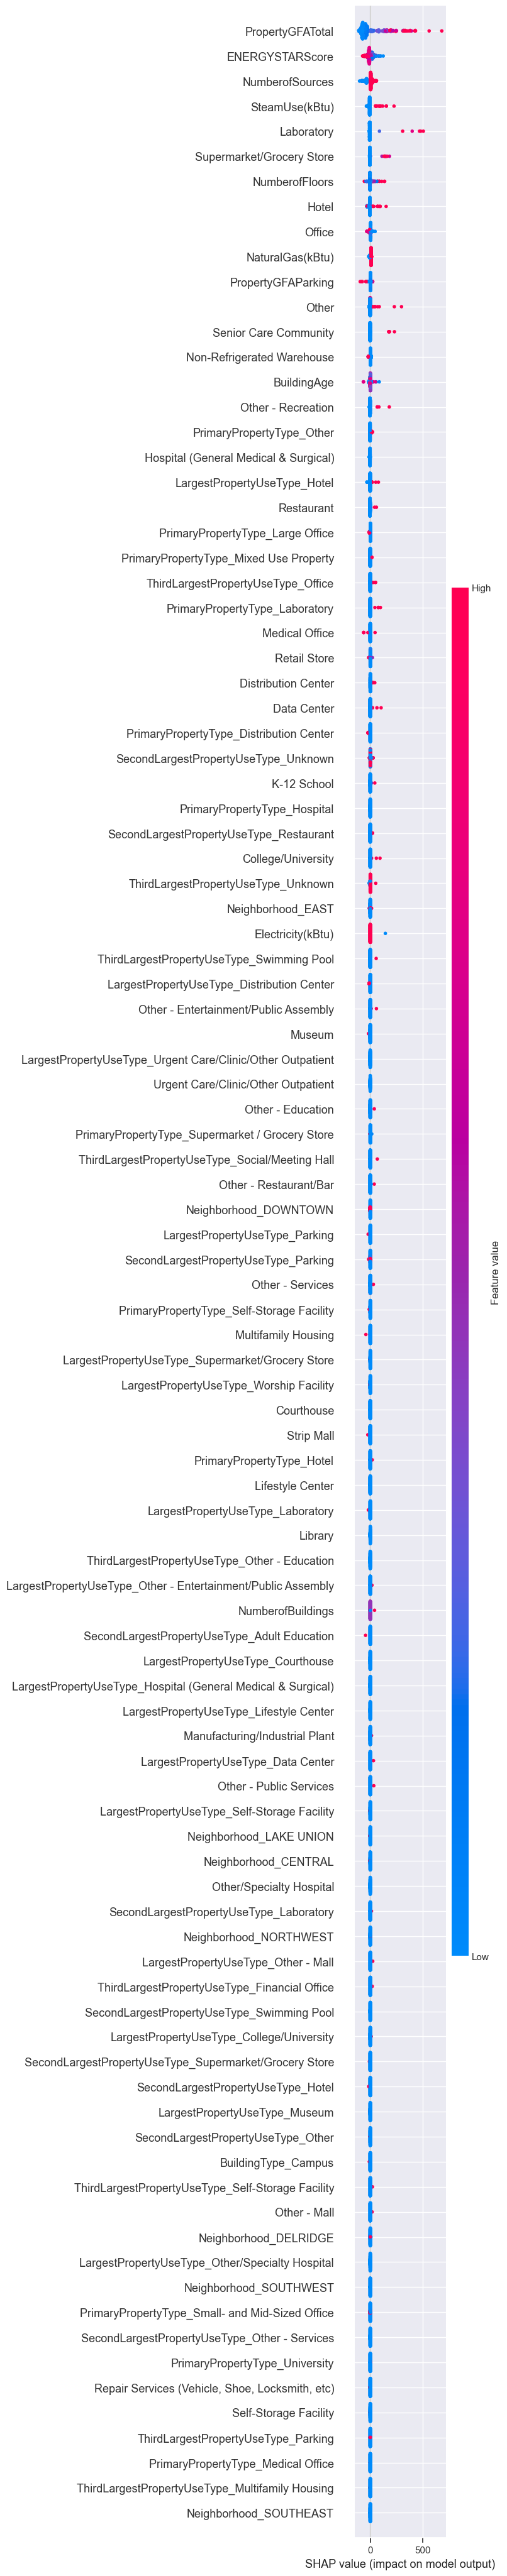

In [21]:
shap.summary_plot(shap_values,features = X_test,max_display=100)


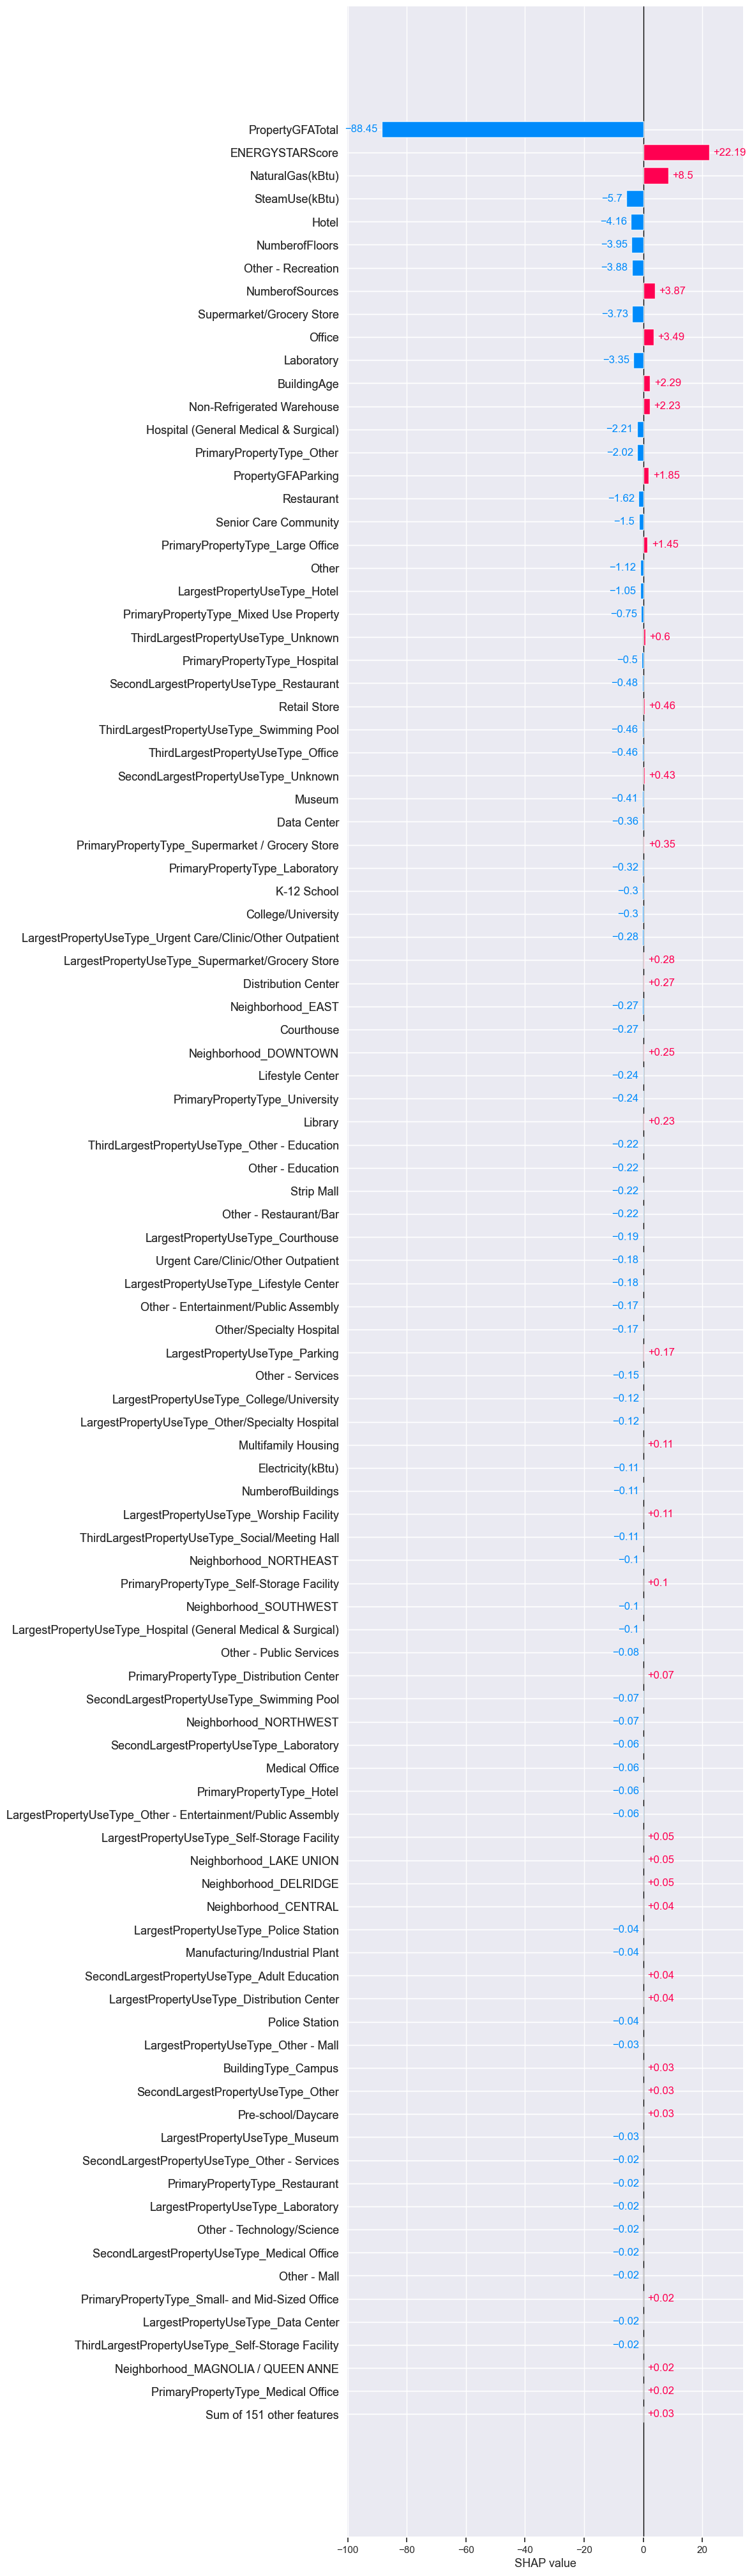

In [22]:
shap.plots.bar(explainer(X_test)[1],max_display=100)


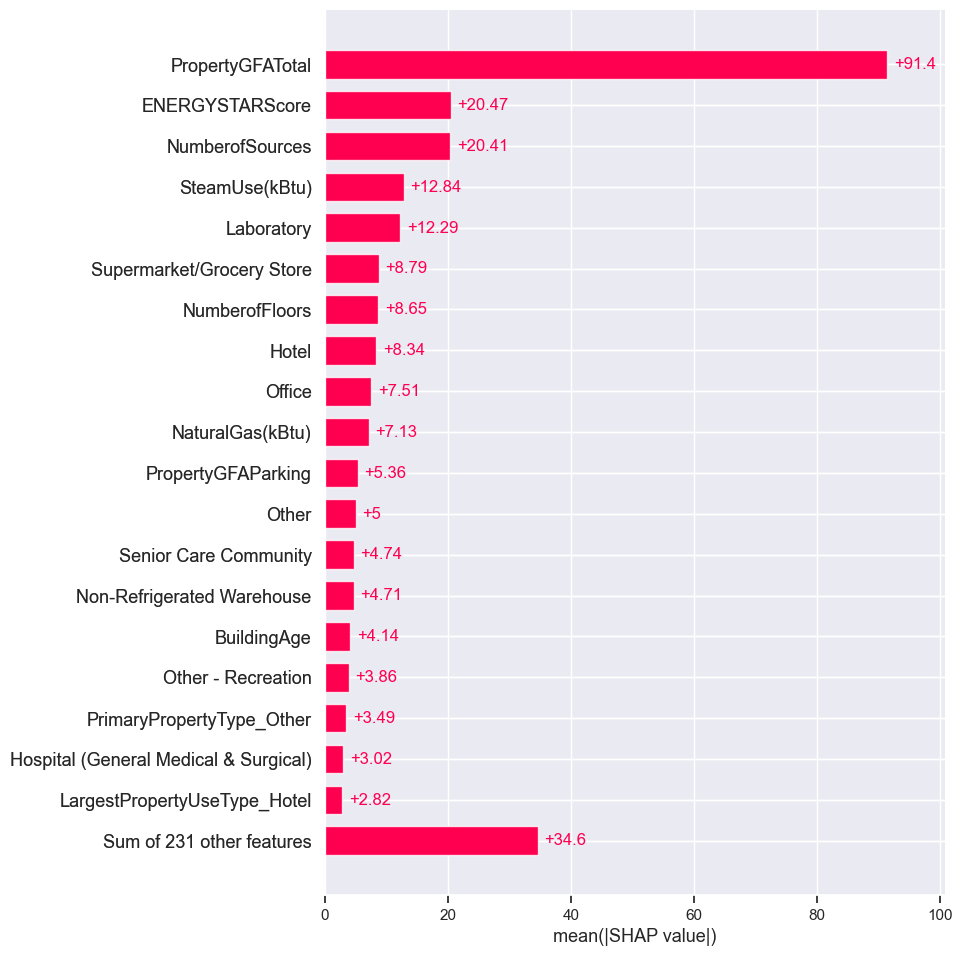

In [23]:
shap.plots.bar(explainer(X_test),max_display=20)


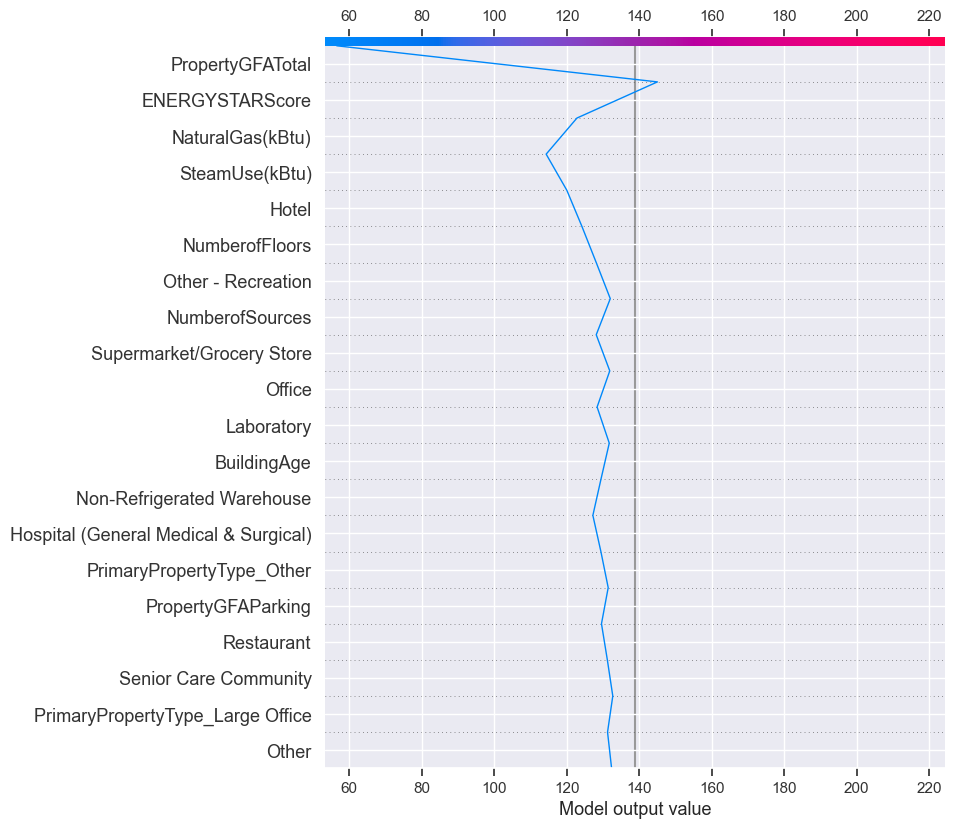

In [24]:
shap.plots.decision(expected_values,shap_values[1],X_train.columns)
